### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

In [ ]:
pip install langchain langchain-openai langgraph pydantic python-dotenv 

Note: you may need to restart the kernel to use updated packages.


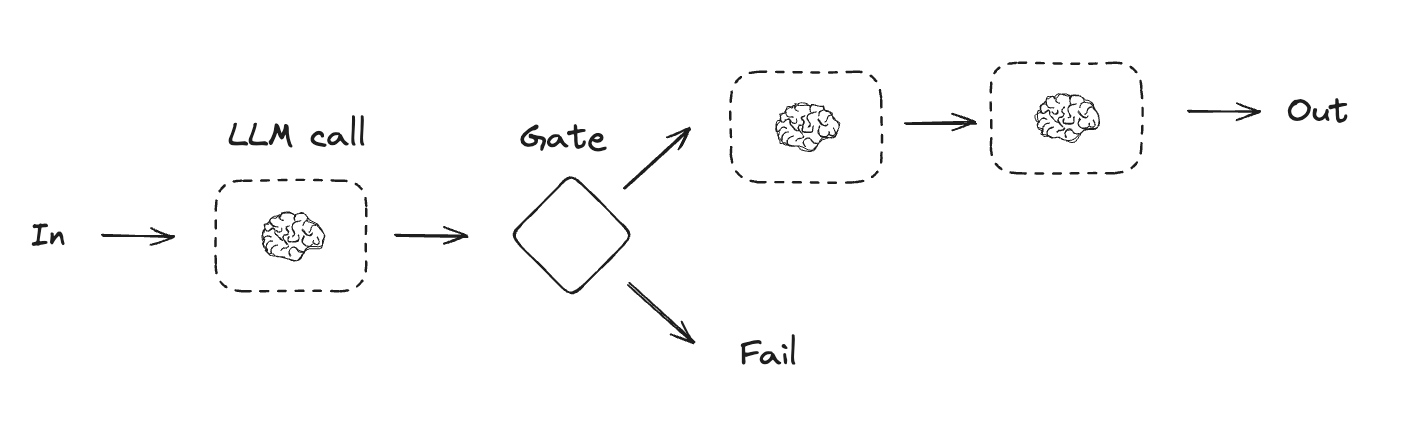

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()

#from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI


os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
#os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result



AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-fb78152b-7a93-480e-b096-8f5d93a3a0ce-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18})

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [13]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



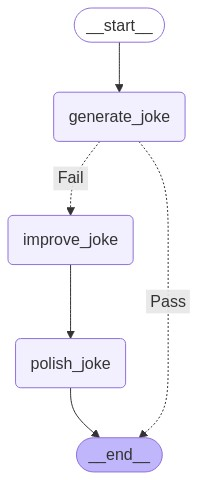

In [14]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))



In [20]:
# Invoke
state = chain.invoke({"topic": "cat"})

In [21]:
state

{'topic': 'cat',
 'joke': 'Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse!',
 'improved_joke': "Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse and make sure it didn't byte off more than it could chew!",
 'final_joke': "Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse and make sure it didn't byte off more than it could chew! Little did it know, the mouse was secretly upgrading the cat's profile on a dating site for felines!"}

In [22]:
state['improved_joke']

"Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse and make sure it didn't byte off more than it could chew!"

In [23]:
state['final_joke']

"Why was the cat sitting on the computer?  \n\nBecause it wanted to keep an eye on the mouse and make sure it didn't byte off more than it could chew! Little did it know, the mouse was secretly upgrading the cat's profile on a dating site for felines!"